In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import mplhep as hep
hep.style.use("CMS")
hep.style.use(hep.style.CMS)

In [2]:
data_directory = "/media/miguel/Elements/zdc_data/zdc_neutron_1to10_fixed_100GeV-100GeV_0.0deg-0.3deg_staggered_h4_03_18_2024/"
file_name = "reco_neutron_fixed_100GeV-100GeV_theta_0.0deg-0.3deg_1-10particles_1624465_0.edm4hep.root"
with ur.open("%s:events"%(data_directory+file_name)) as events:
    branches = events.arrays()
    print(events.num_entries)

5000


Event PDG: [[2112, 2112, 2112, 2112], ..., [2112, 2112, 2112, 2112, ..., 2112, 2112, 2112]]
[[0.107, 0.12, 0.056, 0.253], ..., [0.185, 0.215, 0.176, ..., 0, 0.152, 0]]
27351 27351
[100, 100, 100, 100, 100, 100, 100, 100, ..., 100, 100, 100, 100, 100, 100, 100]


Text(0, 1, 'Summed neutron energy (GeV)')

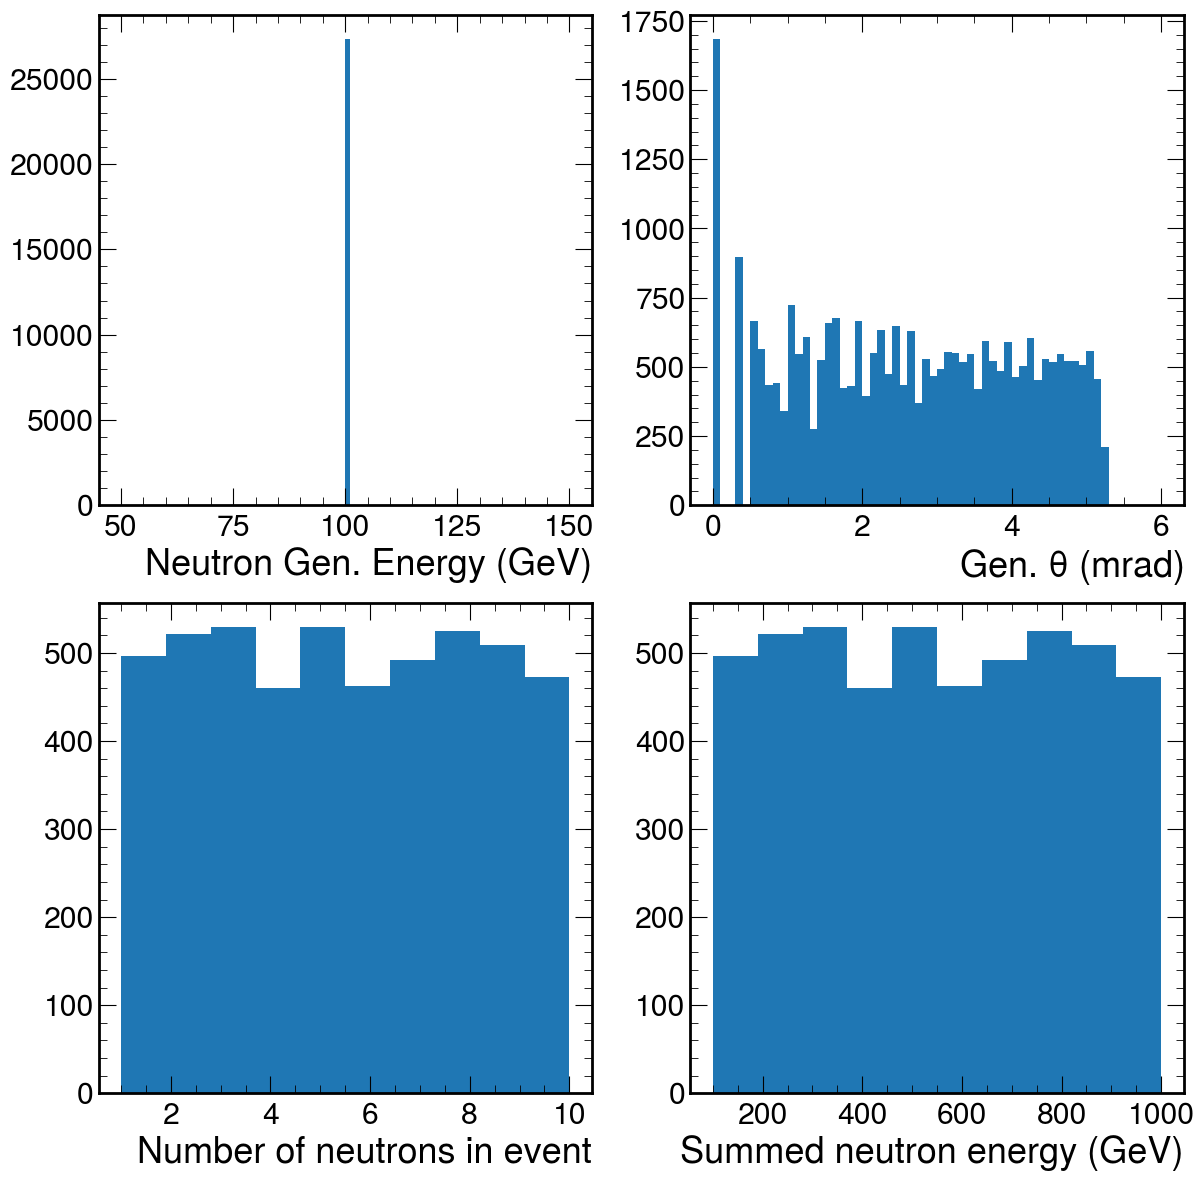

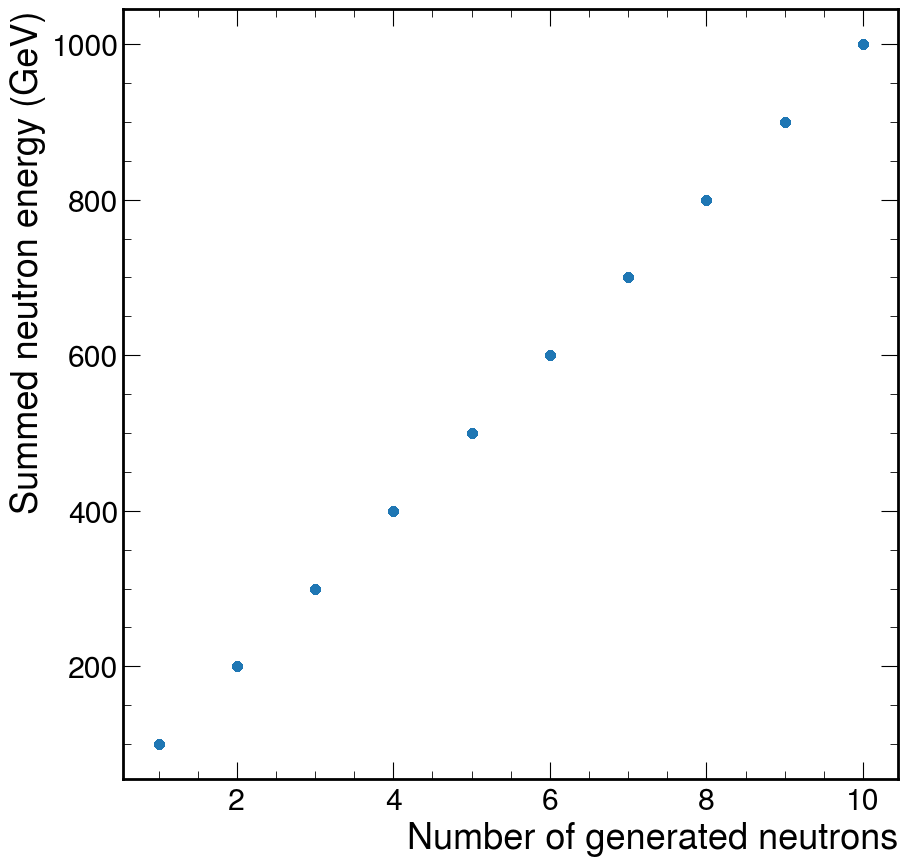

In [3]:
# Obtaining final state particle
incident_mask = branches['MCParticles.generatorStatus']==1
# Getting particle type
gen_pdg = branches["MCParticles.PDG"][incident_mask]
print("Event PDG:",gen_pdg)

# Getting momentum of the particles in the event
gen_px_particle = branches['MCParticles.momentum.x'][incident_mask]
gen_py_particle = branches['MCParticles.momentum.y'][incident_mask]
gen_pz_particle = branches['MCParticles.momentum.z'][incident_mask]
gen_mass_particle = branches['MCParticles.mass'][incident_mask]

num_particles_per_event = ak.count(gen_px_particle, 1)

# Calculating various quantites of generated particles
gen_mom_particle = np.sqrt(gen_px_particle**2 + gen_py_particle**2 + gen_pz_particle**2)
gen_mom_total = ak.sum(gen_mom_particle, axis = 1)
gen_pt_particle = np.sqrt(gen_px_particle**2 + gen_py_particle**2)
gen_energy_particle = np.sqrt(gen_mom_particle**2 + gen_mass_particle**2)
gen_energy_total = ak.sum(gen_energy_particle, axis = 1)
gen_theta_particle = np.arccos(gen_pz_particle/gen_mom_particle)
gen_theta_particle_deg = np.degrees(gen_theta_particle)
print(gen_theta_particle_deg)

print(len(ak.flatten(gen_mom_particle)), len(ak.flatten(gen_theta_particle)))
print(ak.flatten(gen_mom_particle))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,14))

ax1.hist(ak.flatten(gen_energy_particle),bins = 100, range = [50,150])
ax1.set_xlabel('Neutron Gen. Energy (GeV)')

ax2.hist(np.asarray(ak.flatten(gen_theta_particle))*1000, bins=60, range=[0, 6])
ax2.set_xlabel('Gen. $\\theta$ (mrad)')

ax3.hist(num_particles_per_event)
ax3.set_xlabel("Number of neutrons in event")

ax4.hist(gen_energy_total)
ax4.set_xlabel("Summed neutron energy (GeV)")

fig = plt.figure(figsize=(10,10))
plt.scatter(num_particles_per_event, gen_energy_total)
plt.xlabel("Number of generated neutrons")
plt.ylabel("Summed neutron energy (GeV)")

Text(0.5, 1.0, 'Mutiple neutrons: 10-200 GeV')

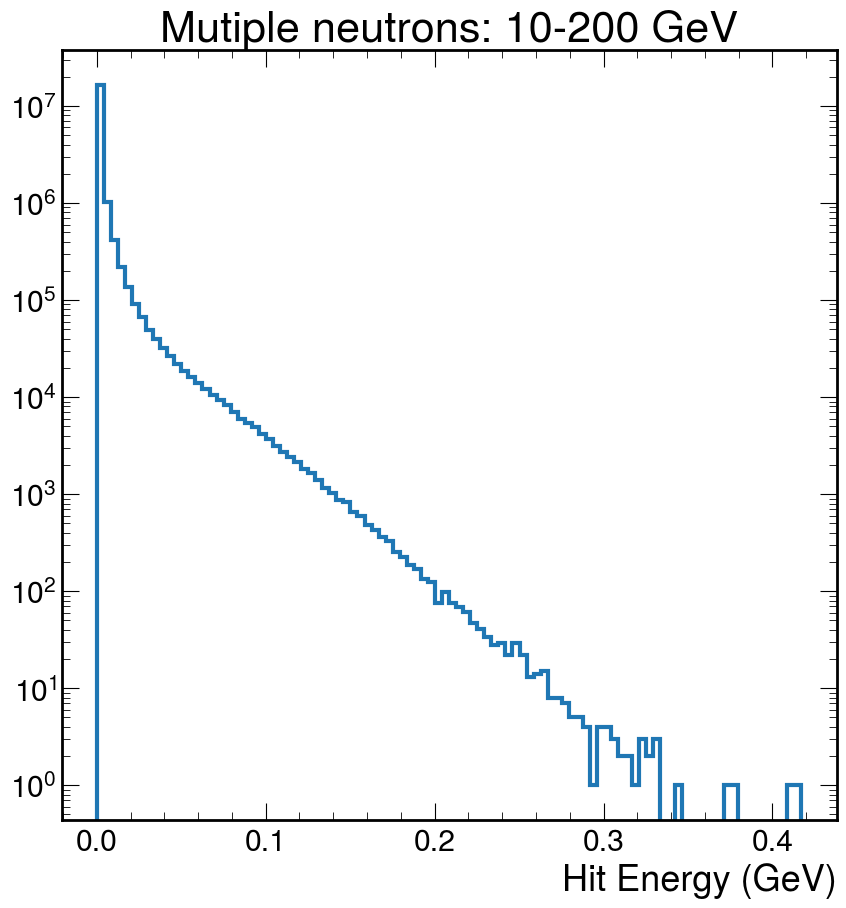

In [4]:
cell_energy = branches['ZDCHcalHitsReco.energy']
min_range=np.min(ak.flatten(cell_energy))
max_range=np.max(ak.flatten(cell_energy))
plt.hist(ak.flatten(cell_energy), bins=100, histtype='step', linewidth=3)
plt.yscale('log')
plt.xlabel("Hit Energy (GeV)")
plt.title("Mutiple neutrons: 10-200 GeV")

445.273274230957


Text(0.5, 1.0, 'ZDC: 10-200 GeV GeV Neutrons \n Num. Neutrons per event = 1-10')

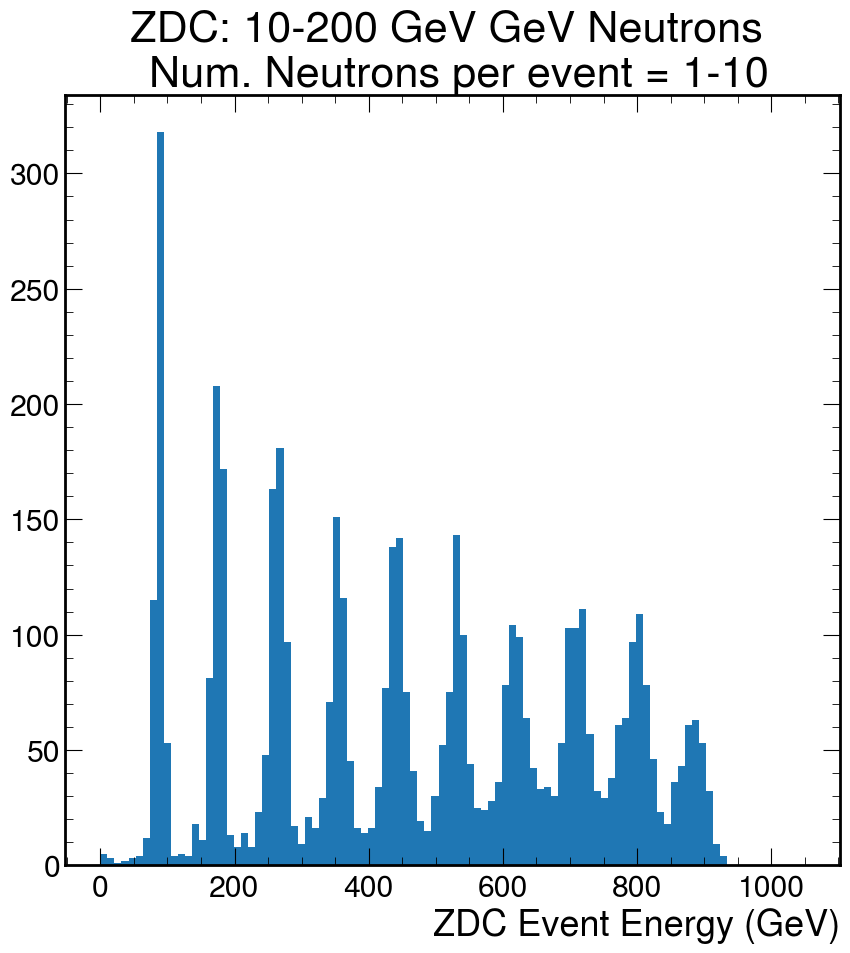

In [5]:
cell_energy = branches['ZDCHcalHitsReco.energy']
sampling_fraction=0.02
MIP_TH=0.5*0.0008
time_TH=275
time =branches['ZDCHcalHitsReco.time']
condition1 = cell_energy > MIP_TH
condition2= time < time_TH
condition3= cell_energy < 1e10
event_energy = np.asarray(ak.sum(cell_energy, axis = 1))
combined_mask = condition1 & condition2 & condition3
hit_e = cell_energy[combined_mask]
event_energy = np.asarray(ak.sum(hit_e, axis = 1))

print(np.mean(np.divide(event_energy, .02))*.95)
low_energy_mask = event_energy/.02 < np.mean(event_energy/.02)*.95
plt.hist(np.divide(event_energy, .02), 100, range=[0, 1050])

plt.xlabel("ZDC Event Energy (GeV)")
plt.title("ZDC: 10-200 GeV GeV Neutrons \n Num. Neutrons per event = 1-10")

Total Sum:  659.4577970958891
-31      32     -32     32      3582        3739
Total Sum:  839.4687289283388
-31      32     -32     32      3582        3739
Total Sum:  665.2087257021949
-31      32     -32     32      3582        3739
Total Sum:  76.33698554266066
-31      32     -32     32      3582        3739
Total Sum:  264.76228804815383
-31      32     -32     32      3582        3739


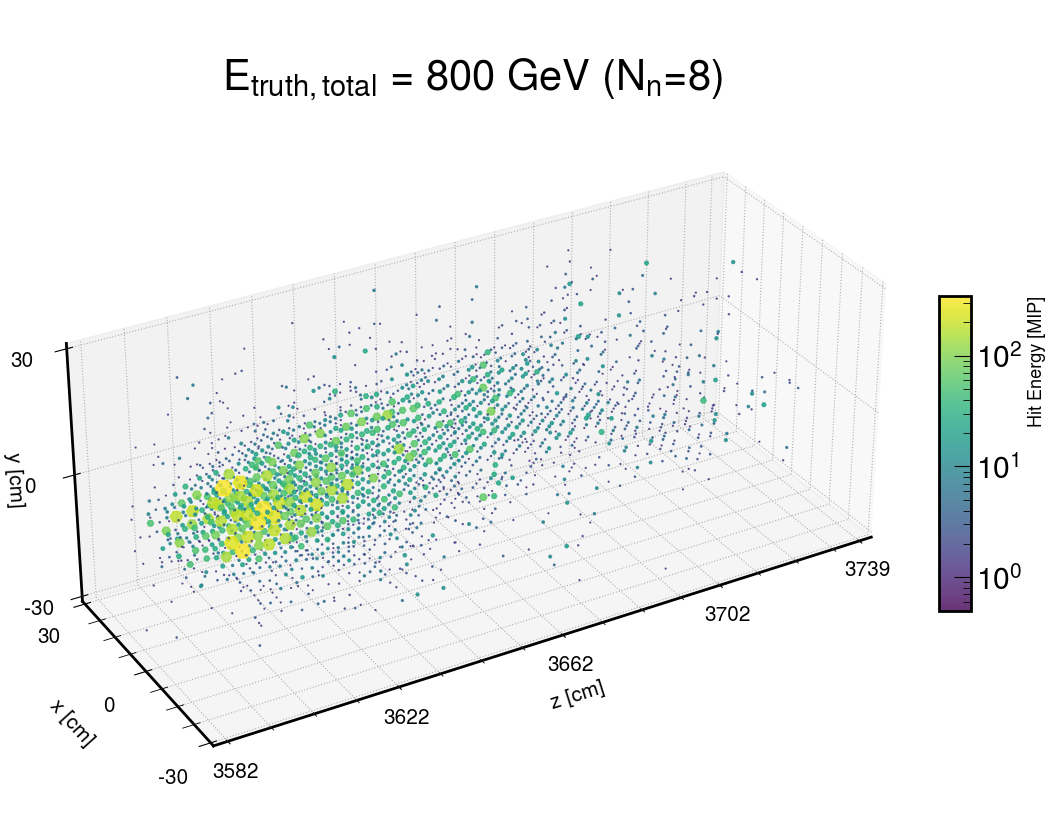

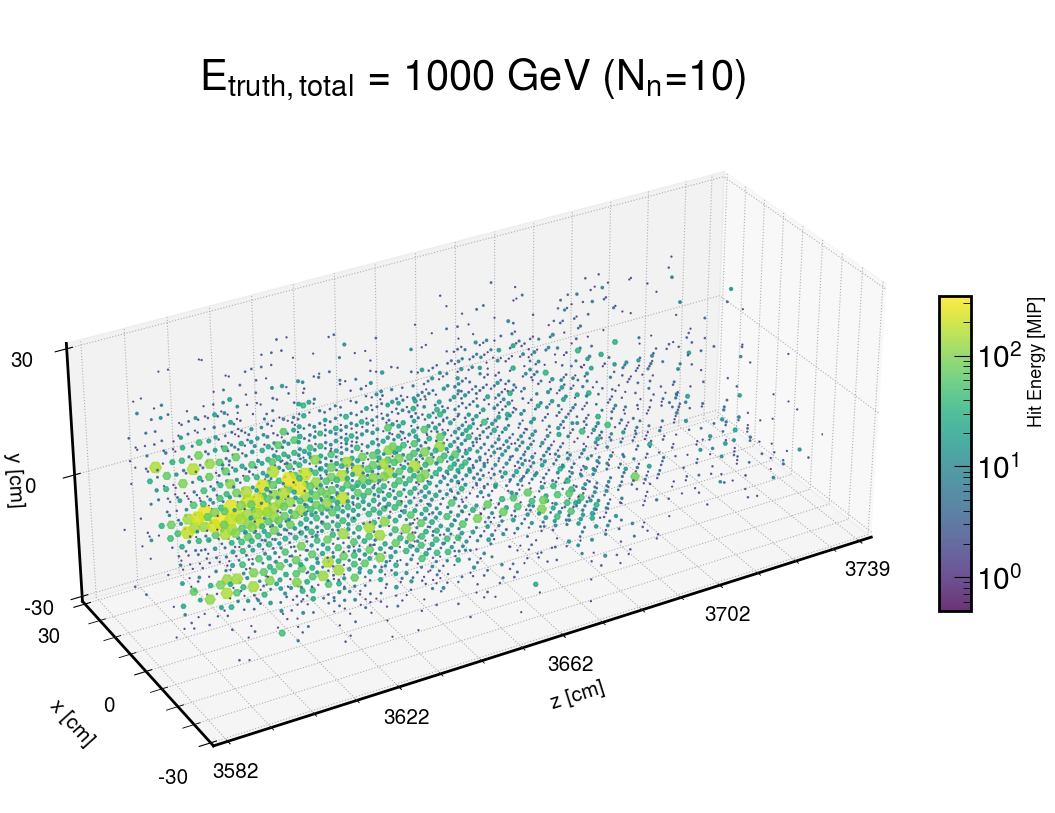

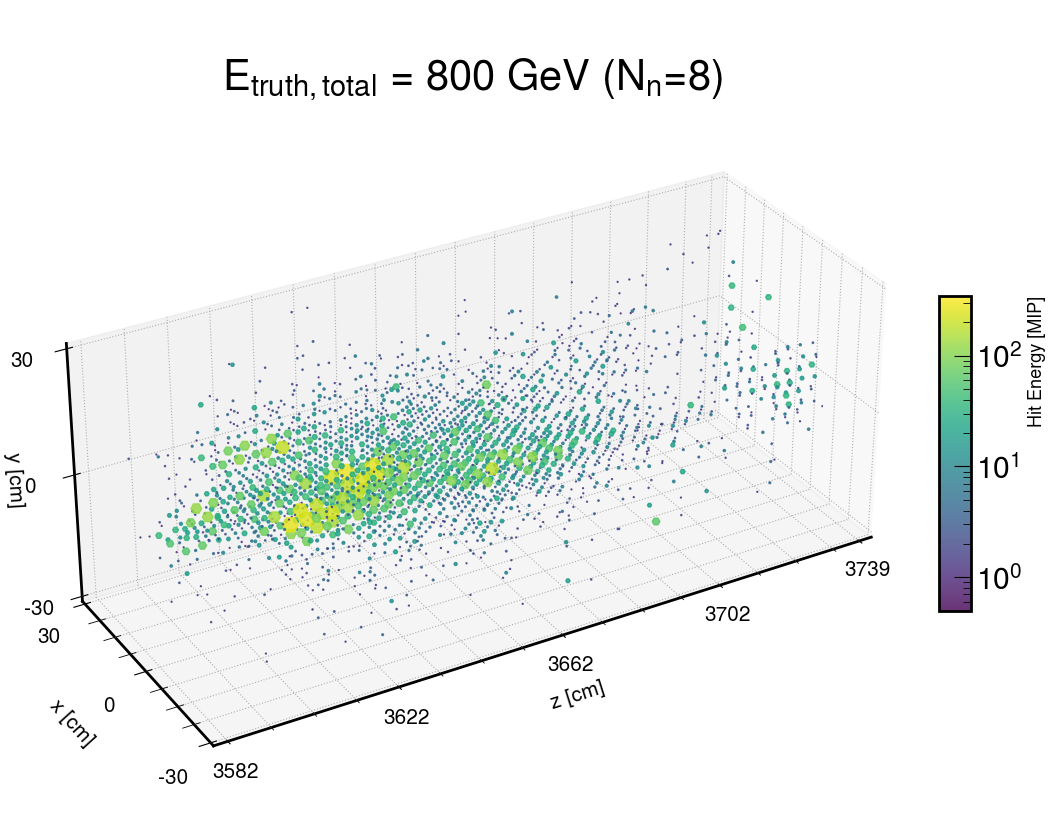

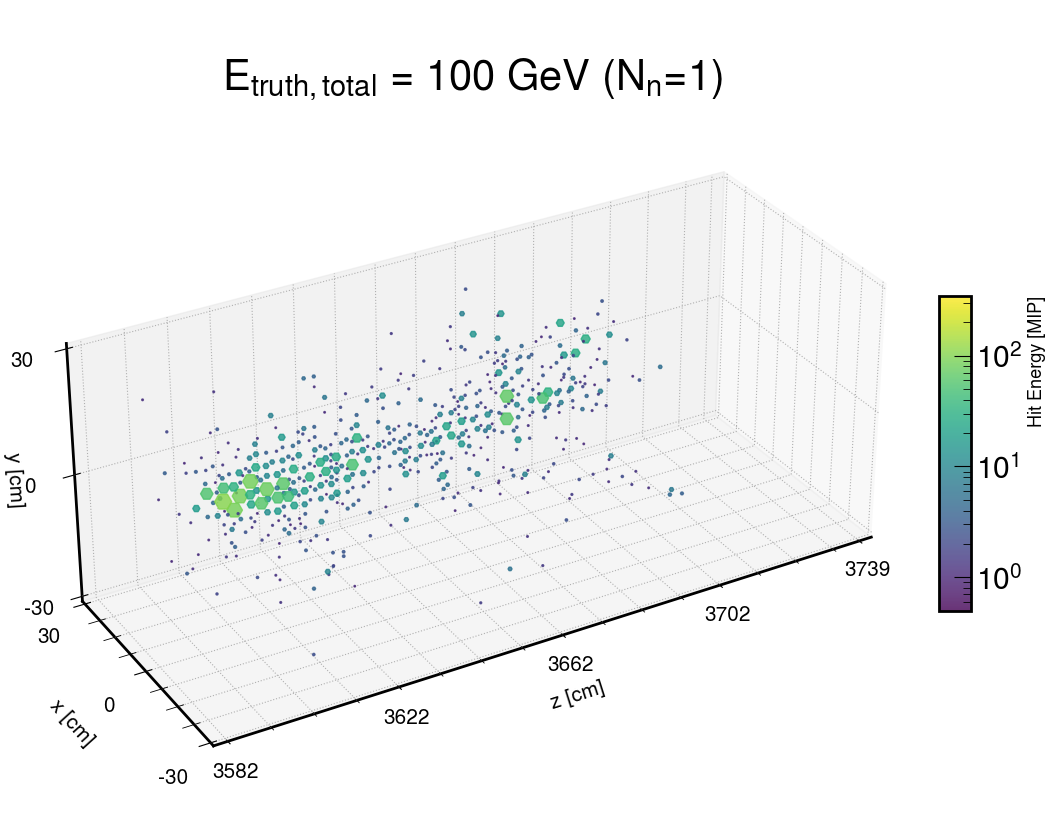

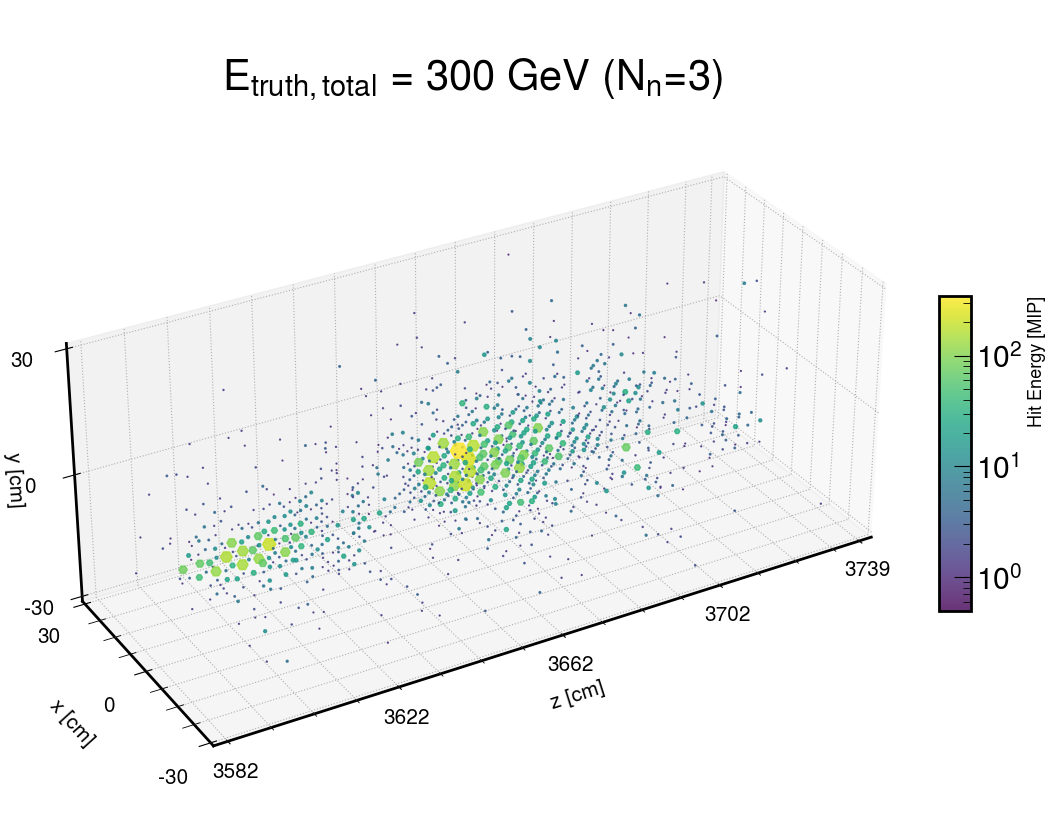

In [6]:
%matplotlib inline
import uproot as ur
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
import sys  

hep.style.use("CMS")
MIP= 0.000472

def get_XYZ_dim(posx, posy, posz):
    x_min=int(np.min(ak.flatten(posx)))
    x_max=int (np.max(ak.flatten(posx)))

    y_min=int(np.min(ak.flatten(posy)))
    y_max=int(np.max(ak.flatten(posy)))

    z_min=int(np.min(ak.flatten(posz)))
    z_max=int(np.max(ak.flatten(posz)))

    return x_min, x_max, y_min, y_max, z_min, z_max
def draw_event(fig, input_file, event, detector):
    scale_canvas=0.9

    if detector=="hcal":
        detector_name = "HcalEndcapPHitsReco"
        MIP_TH=0.5 * 0.0006
        Time_TH=150
        theta_max=600.0
        sampling_fraction=0.0224
    elif detector=='ecal':
        detector_name = "EcalEndcapPHitsReco"
        MIP_TH=0.5 * 0.13
        Time_TH=150
        theta_max=600.0
        sampling_fraction=1.0

    elif detector=="insert":
        detector_name= "HcalEndcapPInsertHitsReco"
        MIP_TH=0.5 * 0.0006
        Time_TH=150.0
        theta_max=600.0
        sampling_fraction=0.0224

    elif detector=="zdc":
        detector_name="ZDCHcalHitsReco"
        MIP_TH=0.5 * .000472
        Time_TH=275.0
        theta_max=10.0
        sampling_fraction=0.021

    else:
        print("Please make sure you have picked right detector name")     
        print("Pick: hcal or hcal_insert for endcap calo/ hcal_insert for insert")


    my_cmap = plt.get_cmap('viridis')

    events = ur.open(f'{input_file}:events')
    num_entries = events.num_entries
    arrays_sim = events.arrays()
    E=arrays_sim[f'{detector_name}.energy'][event,:]
    nhits=len(E)

    x=arrays_sim[f'{detector_name}.position.x'][event,:]/10.
    y=arrays_sim[f'{detector_name}.position.y'][event,:]/10.
    z=arrays_sim[f'{detector_name}.position.z'][event,:]/10.

    incident_mask = arrays_sim["MCParticles.generatorStatus"]==1
    num_particles = len(arrays_sim["MCParticles.PDG"][incident_mask][event])
    genPx = arrays_sim['MCParticles.momentum.x'][incident_mask][event]
    genPy = arrays_sim['MCParticles.momentum.y'][incident_mask][event]
    genPz = arrays_sim['MCParticles.momentum.z'][incident_mask][event]
    mom=np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
    if num_particles > 1:
        total_mom = ak.sum(mom)
    elif num_particles == 1:
        total_mom = mom[0]
    theta=np.arccos(genPz/mom)*1000  #    *180/np.pi
    total_mom=round(total_mom, 2)
    total_mom = int(total_mom)

    slc=E>MIP

    ax1 = fig.add_subplot(211, projection='3d',azim=-120, elev=30)

    sctt3d = ax1.scatter3D(z[slc], x[slc], y[slc],
                    alpha = 0.8,
                    c = E[slc]/MIP,
                    s=150*E[slc]/np.max(E[slc]),
                    cmap = my_cmap,
                    norm=mpl.colors.LogNorm(),
                    marker ='H')


    print('Total Sum: ',ak.sum(E[slc]) /sampling_fraction)
    sctt3d.set_clim(vmin=0.5, vmax=350)
    cbar = fig.colorbar(sctt3d, shrink=0.45, pad=0.05, aspect=10)
    cbar.set_label('Hit Energy [MIP]', fontsize=13)


    x_min, x_max, y_min, y_max, z_min, z_max=get_XYZ_dim(arrays_sim[f'{detector_name}.position.x']/10.,\
                                                        arrays_sim[f'{detector_name}.position.y']/10.,\
                                                        arrays_sim[f'{detector_name}.position.z']/10.)
    print(x_min, '    ', x_max, '   ', y_min, '   ', y_max, '    ', z_min, '      ', z_max)
    max_val_for_plot=round(np.max([x_max, y_max])/10) *10

    plt.ylim(-max_val_for_plot,max_val_for_plot) #x
    plt.gca().set_zlim(-max_val_for_plot, max_val_for_plot) #y    
    z_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)
    y_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)

    ax1.set_zticks(z_ticks)
    ax1.set_yticks(y_ticks)
    specific_values = np.array([z_min, z_max])
    x_ticks = np.arange(z_min, z_max, 40)

    # Concatenate the specific values with the generated array
    x_ticks = np.append(x_ticks, [z_max])
    ax1.set_xticks(x_ticks)

    plt.gca().zaxis.labelpad = -2
    num_neutrons = ak.count(mom)
    ax1.set_title(f" \n$E_{{truth,total}}$ = {total_mom} GeV ($N_{{n}}$={num_neutrons})", fontsize=30, pad=-500)
    plt.gca().set_xlabel("\n\nz [cm]", fontsize=15)
    plt.gca().set_ylabel("\nx [cm]", fontsize=15)
    plt.gca().set_zlabel("y [cm]", fontsize=15)
    plt.gca().set_xlim(z_min, z_max)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().zaxis.set_tick_params(labelsize=15)

    plt.gca().set_box_aspect((180,70,70), zoom=1.2)
    return ax1


file_path=data_directory+file_name
detector='zdc'
fig=plt.figure( figsize=(30,20))
draw_event(fig, file_path, 5, detector)

fig=plt.figure( figsize=(30,20))
ax2=draw_event(fig, file_path, 6, detector)

fig=plt.figure( figsize=(30,20))
ax2=draw_event(fig, file_path, 7, detector)

fig=plt.figure( figsize=(30,20))
ax2=draw_event(fig, file_path, 8, detector)

fig=plt.figure( figsize=(30,20))
ax2=draw_event(fig, file_path, 9, detector)
